Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Random Forest Accuracy: 0.33
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.26      0.28       324
           1       0.33      0.36      0.34       341
           2       0.37      0.37      0.37       335

    accuracy                           0.33      1000
   macro avg       0.33      0.33      0.33      1000
weighted avg       0.33      0.33      0.33      1000

XGBoost Accuracy: 0.32
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.29      0.30       324
           1       0.32      0.34      0.33       341
           2       0.34      0.33      0.34       335

    accuracy                           0.32      1000
   macro avg       0.32      0.32     

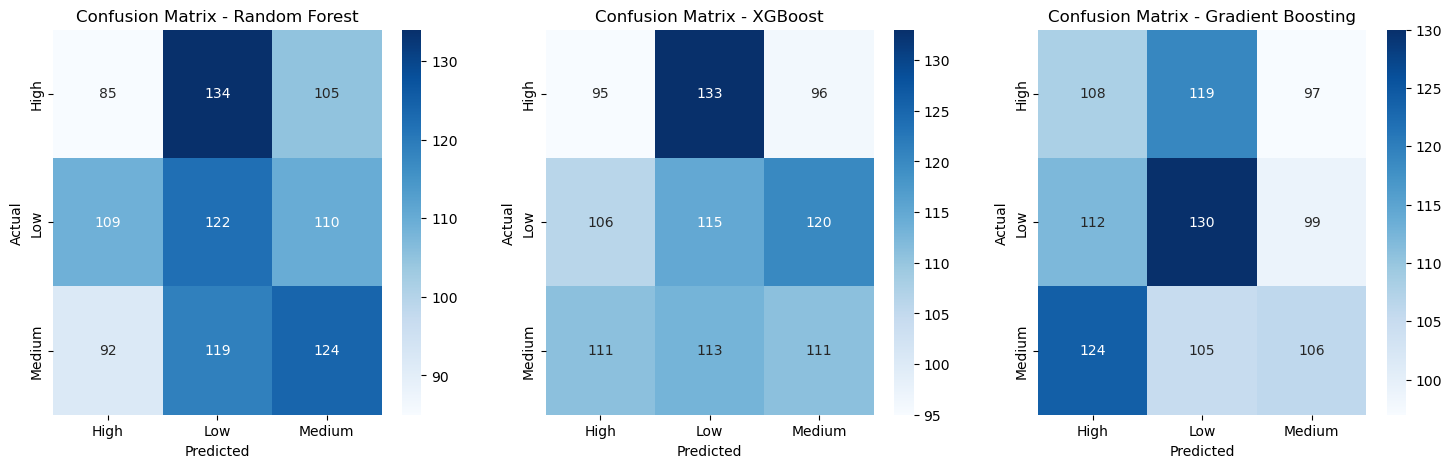

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Load dataset
file_path = "Elite Sports Cars in Data.csv"
df = pd.read_csv(file_path)

# Drop irrelevant columns
df_cleaned = df.drop(columns=["Brand", "Model", "Country", "Modification", "Log_Price", "Log_Mileage"])

# Encode categorical variables
categorical_cols = ["Condition", "Fuel_Type", "Drivetrain", "Transmission", "Popularity", "Market_Demand"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

# Separate features and target variable
X = df_cleaned.drop(columns=["Market_Demand"])
y = df_cleaned["Market_Demand"]

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_

# Train XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = best_rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Evaluate models
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

report_rf = classification_report(y_test, y_pred_rf)
report_xgb = classification_report(y_test, y_pred_xgb)
report_gb = classification_report(y_test, y_pred_gb)

print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("Random Forest Classification Report:\n", report_rf)

print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")
print("XGBoost Classification Report:\n", report_xgb)

print(f"Gradient Boosting Accuracy: {accuracy_gb:.2f}")
print("Gradient Boosting Classification Report:\n", report_gb)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, model_name, y_pred in zip(axes, ["Random Forest", "XGBoost", "Gradient Boosting"], [y_pred_rf, y_pred_xgb, y_pred_gb]):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders['Market_Demand'].classes_, yticklabels=label_encoders['Market_Demand'].classes_, ax=ax)
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.show()
